In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
prasadvpatil_mrl_dataset_path = kagglehub.dataset_download('prasadvpatil/mrl-dataset')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mrl-dataset/train/Open_Eyes/s0014_08315_0_0_1_1_0_02.png
/kaggle/input/mrl-dataset/train/Open_Eyes/s0036_03092_1_0_1_0_0_01.png
/kaggle/input/mrl-dataset/train/Open_Eyes/s0014_07653_0_0_1_1_1_02.png
/kaggle/input/mrl-dataset/train/Open_Eyes/s0019_06130_0_0_1_0_0_01.png
/kaggle/input/mrl-dataset/train/Open_Eyes/s0001_02878_0_1_1_0_1_01.png
/kaggle/input/mrl-dataset/train/Open_Eyes/s0012_08642_0_0_1_1_0_02.png
/kaggle/input/mrl-dataset/train/Open_Eyes/s0014_08319_0_0_1_1_0_02.png
/kaggle/input/mrl-dataset/train/Open_Eyes/s0012_07611_0_1_1_2_0_01.png
/kaggle/input/mrl-dataset/train/Open_Eyes/s0012_04571_0_0_1_0_1_03.png
/kaggle/input/mrl-dataset/train/Open_Eyes/s0019_06033_0_0_1_0_0_01.png
/kaggle/input/mrl-dataset/train/Open_Eyes/s0014_07463_0_0_1_2_1_02.png
/kaggle/input/mrl-dataset/train/Open_Eyes/s0019_06024_0_0_1_0_0_01.png
/kaggle/input/mrl-dataset/train/Open_Eyes/s0012_08659_0_0_1_1_0_02.png
/kaggle/input/mrl-dataset/train/Open_Eyes/s0012_07912_0_0_1_1_0_02.png
/kaggl

In [ ]:
import random
import os
import glob
from sklearn.model_selection import train_test_split

In [ ]:
data_dir = '/kaggle/input/mrl-dataset/train'

images = []
labels = []


for label in ['Closed_Eyes', 'Open_Eyes']:
    img_dir = os.path.join(data_dir, label)
    img_paths = glob.glob(os.path.join(img_dir, '*.png'))

    images.extend(img_paths)
    labels.extend([label] * len(img_paths))

y = [0 if l == 'Closed_Eyes' else 1 for l in labels]

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
# 1. Dataset size and class distribution
print(f"Total images: {len(images)}")
class_counts = Counter(labels)
print("Class distribution:")
for cls, count in class_counts.items():
    print(f"  {cls}: {count}")

Total images: 4000
Class distribution:
  Closed_Eyes: 2000
  Open_Eyes: 2000


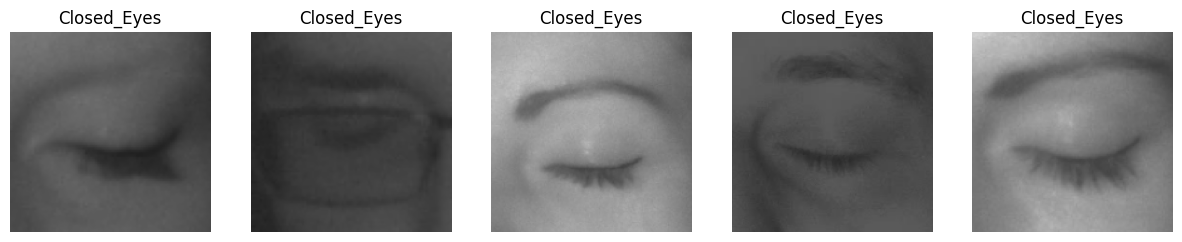

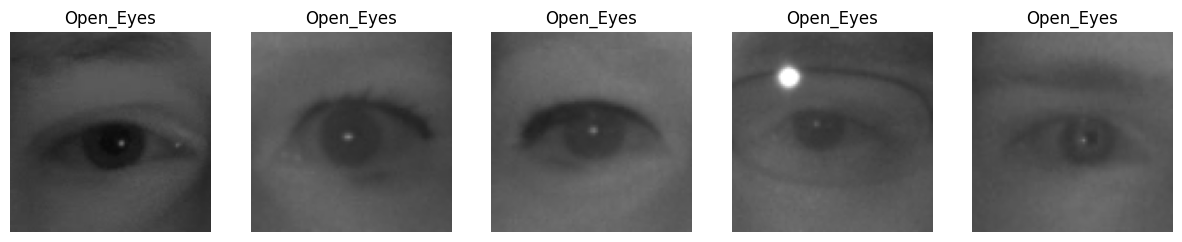

In [ ]:
#Display some random images from each class
def show_random_images(class_name, n=5):
    class_images = [img for img, lbl in zip(images, labels) if lbl == class_name]
    samples = random.sample(class_images, min(n, len(class_images)))

    plt.figure(figsize=(15,3))
    for i, img_path in enumerate(samples):
        img = Image.open(img_path).convert('RGB')
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"{class_name}")
        plt.axis('off')
    plt.show()

show_random_images('Closed_Eyes', n=5)
show_random_images('Open_Eyes', n=5)

In [ ]:
# Check image sizes and channels
w,h = [], []
for i in images:
    img = Image.open(i)
    w.append(img.width)
    h.append(img.height)

print(f"Image width: min={min(w)}, max={max(w)}, mean={sum(w)/len(w):.2f}")
print(f"Image height: min={min(h)}, max={max(h)}, mean={sum(h)/len(h):.2f}")

Image width: min=60, max=180, mean=107.31
Image height: min=60, max=180, mean=107.31


In [ ]:
#Check image modes
modes = Counter()
for i in images[:100]:
    img = Image.open(i)
    modes[img.mode] += 1
print("Image modes in sample of 100 images:", dict(modes))

Image modes in sample of 100 images: {'L': 100}


In [ ]:
#importing libraries
from torch import nn
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim
from torchvision import transforms, utils, models

from collections import OrderedDict

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size = 0.2, random_state=42)

In [ ]:
#making custom tarnsform for resnet18 for tarnsfer learning

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, features, labels, transforms):
        self.features = features
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        image = Image.open(self.features[index]).convert('RGB')

        if self.transforms:
            image = self.transforms(image)

        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.long)

        return image, label


In [ ]:
img = Image.open(images[0])
print(f"Image size: {img.size}")

Image size: (108, 108)


In [ ]:
train_dataset = CustomDataset(X_train, y_train, transforms=train_transform)
test_dataset = CustomDataset(X_test, y_test, transforms=test_transform)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle = True, num_workers=4, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, pin_memory = True)

In [ ]:
from torchvision import models
model = models.resnet18(weights = True)

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#freeze all the layers except fully connected layers

for name, param in model.named_parameters():
    if "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 2)
)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
from torch.optim.lr_scheduler import StepLR

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
epochs = 20

for epoch in range(epochs):
    model.train()

    running_loss = 0.0
    running_corrects = 0

    for batch_feature, batch_label in train_loader:
        batch_feature, batch_label = batch_feature.to(device), batch_label.to(device)

        # Forward pass
        output = model(batch_feature)
        loss = criterion(output, batch_label)

        # Backprop & update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss & correct predictions
        running_loss += loss.item() * batch_feature.size(0)
        _, preds = torch.max(output, 1)
        running_corrects += torch.sum(preds == batch_label).item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects / len(train_loader.dataset)

    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0

    with torch.no_grad():
        for val_features, val_labels in test_loader:
            val_features, val_labels = val_features.to(device), val_labels.to(device)
            outputs = model(val_features)
            loss = criterion(outputs, val_labels)

            val_running_loss += loss.item() * val_features.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == val_labels).item()

    epoch_val_loss = val_running_loss / len(test_loader.dataset)
    epoch_val_acc = val_running_corrects / len(test_loader.dataset)

    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)
    scheduler.step()
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")


Epoch [1/20] Train Loss: 0.1190 | Train Acc: 0.9544 | Val Loss: 0.0018 | Val Acc: 0.9988
Epoch [2/20] Train Loss: 0.0084 | Train Acc: 0.9969 | Val Loss: 0.0001 | Val Acc: 1.0000
Epoch [3/20] Train Loss: 0.0034 | Train Acc: 0.9991 | Val Loss: 0.0000 | Val Acc: 1.0000
Epoch [4/20] Train Loss: 0.0008 | Train Acc: 0.9997 | Val Loss: 0.0000 | Val Acc: 1.0000
Epoch [5/20] Train Loss: 0.0042 | Train Acc: 0.9988 | Val Loss: 0.0001 | Val Acc: 1.0000
Epoch [6/20] Train Loss: 0.0015 | Train Acc: 0.9997 | Val Loss: 0.0000 | Val Acc: 1.0000
Epoch [7/20] Train Loss: 0.0006 | Train Acc: 0.9997 | Val Loss: 0.0000 | Val Acc: 1.0000
Epoch [8/20] Train Loss: 0.0016 | Train Acc: 0.9997 | Val Loss: 0.0000 | Val Acc: 1.0000
Epoch [9/20] Train Loss: 0.0003 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000
Epoch [10/20] Train Loss: 0.0001 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000
Epoch [11/20] Train Loss: 0.0002 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000
Epoch [12/20] Train

In [ ]:
 model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Test Accuracy: 100.00%


In [ ]:
torch.save(model.state_dict(), 'eye_detector2.pth')

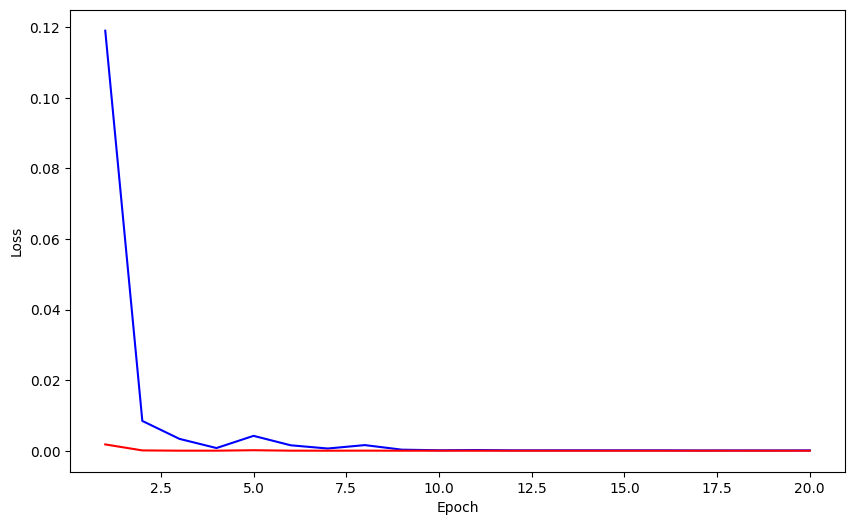

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_loss) + 1)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Loss on left y-axis
ax1.plot(epochs_range, train_loss, 'b-', label='Train Loss')
ax1.plot(epochs_range, val_loss, 'r-', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='black')
ax1.tick_params(axis='y', labelcolor='black')

In [ ]:
# Create second y-axis for Accuracy
ax2 = ax1.twinx()
ax2.plot(epochs_range, train_acc, 'b--', label='Train Accuracy')
ax2.plot(epochs_range, val_acc, 'r--', label='Validation Accuracy')
ax2.set_ylabel('Accuracy', color='black')
ax2.tick_params(axis='y', labelcolor='black')

In [ ]:
# Create second y-axis for Accuracy
ax2 = ax1.twinx()
ax2.plot(epochs_range, train_acc, 'b--', label='Train Accuracy')
ax2.plot(epochs_range, val_acc, 'r--', label='Validation Accuracy')
ax2.set_ylabel('Accuracy', color='black')
ax2.tick_params(axis='y', labelcolor='black')

Accuracy on Test set: 1.0
Confusion matrix:
 [[422   0]
 [  0 378]]
Classification report:
               precision    recall  f1-score   support

 Closed_Eyes       1.00      1.00      1.00       422
   Open_Eyes       1.00      1.00      1.00       378

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



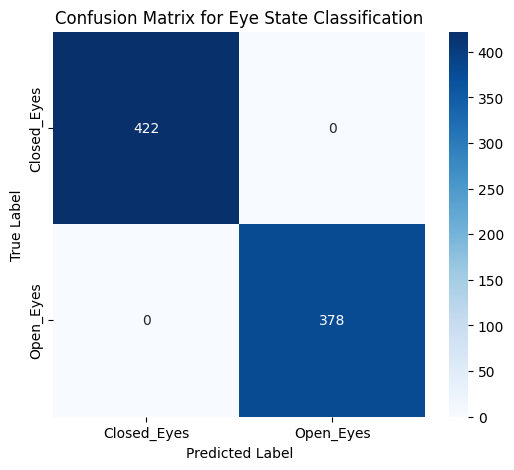

In [ ]:

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sn
import pandas as pd

model.eval()

# Containers for true & predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Class names
classes = ['Closed_Eyes', 'Open_Eyes']

# Accuracy
print("Accuracy on Test set:", accuracy_score(y_true, y_pred))

# Confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion matrix:\n', cf_matrix)

# Classification report
print('Classification report:\n', classification_report(y_true, y_pred, target_names=classes))

# Plot confusion matrix
df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)

plt.figure(figsize=(6, 5))
plt.title("Confusion Matrix for Eye State Classification")
sn.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
